# Synthesized Observations

We use Maria to generate synthetic mock observations for bolometric arrays installed on single-dish telescopes. We have developed a wrapper called 'Simulation,' which emulates telescopes like ACT, Toltec, GBT, and AtLAST. This wrapper generates time-ordered domain (TOD) data. By simulating distinct atmospheric layers corresponding to the designated site within the simulation, we allow the mock array to sweep across the input celestial sky while scanning through evolving atmosphere. As a result, the TODs produced combine elements of the real sky, atmospheric effects. This approach generates synthetic observations taking into account atmospheric filtering. 

This tutorial will guide you through the process of setting up the simulation tool and creating your own mock observations.

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np

In [2]:
from maria import Simulation
from maria import mappers

## Setting up a MUSTANG-2 Simulation
The ```Simulation``` class offers flexibility for customizing atmospheric simulations. You can configure it to replicate observatories like 'AtLAST' at the APEX site or simulate specific observations, such as MUSTANG-2, under different weather conditions by adjusting the 'weather_quantiles' parameter within the Simulation keywords.

Additionally, the ```Simulation``` class allows you to explore how different scanning strategies impact large-scale filtering. Standard strategies, like back-and-forth or Daisy scan patterns, are implemented for this purpose. For comprehensive documentation on all available keywords, please refer to our detailed documentation. 

Now, let's initiate an example of a mock observation involving a galaxy cluster merger event at redshift 1, observed via the SZ effect, using the Mustang-2 instrument:

### Initialize
First we need to initialize the telescope and weather conditions

In [3]:
pointing_center = (150.0, 10.0)
pixel_size = 0.0001
integration_time = 10.0 * 60.0

inputfile = "../../../maps/protocluster.fits"

In [4]:
sim = Simulation(
    # Mandatory minimal weither settings
    # ---------------------
    array="MUSTANG-2",  # Array type
    pointing="daisy",  # Scanning strategy
    site="GBT",  # Site
    atm_model=None,#"single_layer",  # The atmospheric model, set to None if you want a noiseless observation.
    # True sky input
    # ---------------------
    map_file=inputfile,  # Input files must be a fits file.
    # map_file can also be set to None if are only interested in the noise
    map_center=pointing_center,  # RA & Dec in degree
    # MUSTANG-2 Observational setup
    # ----------------------------
    integration_time=integration_time,  # Seconds
    sample_rate=100,  # Hz
    scan_center=pointing_center,  # Degrees
    pointing_frame="ra_dec",  # Frame
    scan_radius=3 / 60.0,  # The radius of the Daisy scan in degrees
    # Additional inputs:
    # ----------------------
    weather_quantiles={
        "column_water_vapor": 0.1
    },  # Weather conditions specific for that site
    map_units="Jy/pixel",  # Units of the input map in Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel
    map_res=pixel_size,  # degree, overwrites header information
)

### Obtaining time-ordered data (TODs)
To acquire time-ordered data (TODs), you only need to run the script. The TOD object contains time stamps, coordinates (in RA and Dec), and the intensity of each scan for every detector. The intensity units are consistently expressed in surface brightness temperature units: Kelvin Rayleigh-Jeans (Even if the input map is given in Jy/pixel. We convert the units under the hood).

In [6]:
tod = sim.run()

### Usefull visualizations:
Before proceeding, we first need to adjust the input sky as specified in the Simulation class above.

In [7]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

# - Input figure
hdu = fits.open(inputfile)

hdu[0].data = hdu[0].data
header = hdu[0].header
header["CDELT1"] = pixel_size  # degree
header["CDELT2"] = pixel_size  # degree
header["CTYPE1"] = "RA---SIN"
header["CUNIT1"] = "deg     "
header["CTYPE2"] = "DEC--SIN"
header["CUNIT2"] = "deg     "
header["CRVAL1"] = pointing_center[0]
header["CRVAL2"] = pointing_center[1]
wcs_input = WCS(header, naxis=2)

Now, let's visualize the scanning strategy and the TOD. The top two panels display the scanning trajectory in the elevation and azimuthal plane, while on the right, we present it on the celestial plane. This allows you to check if the scanning pattern aligns with the astronomical source.

The two bottom panels show the mean powerspectra and time series of the observations.

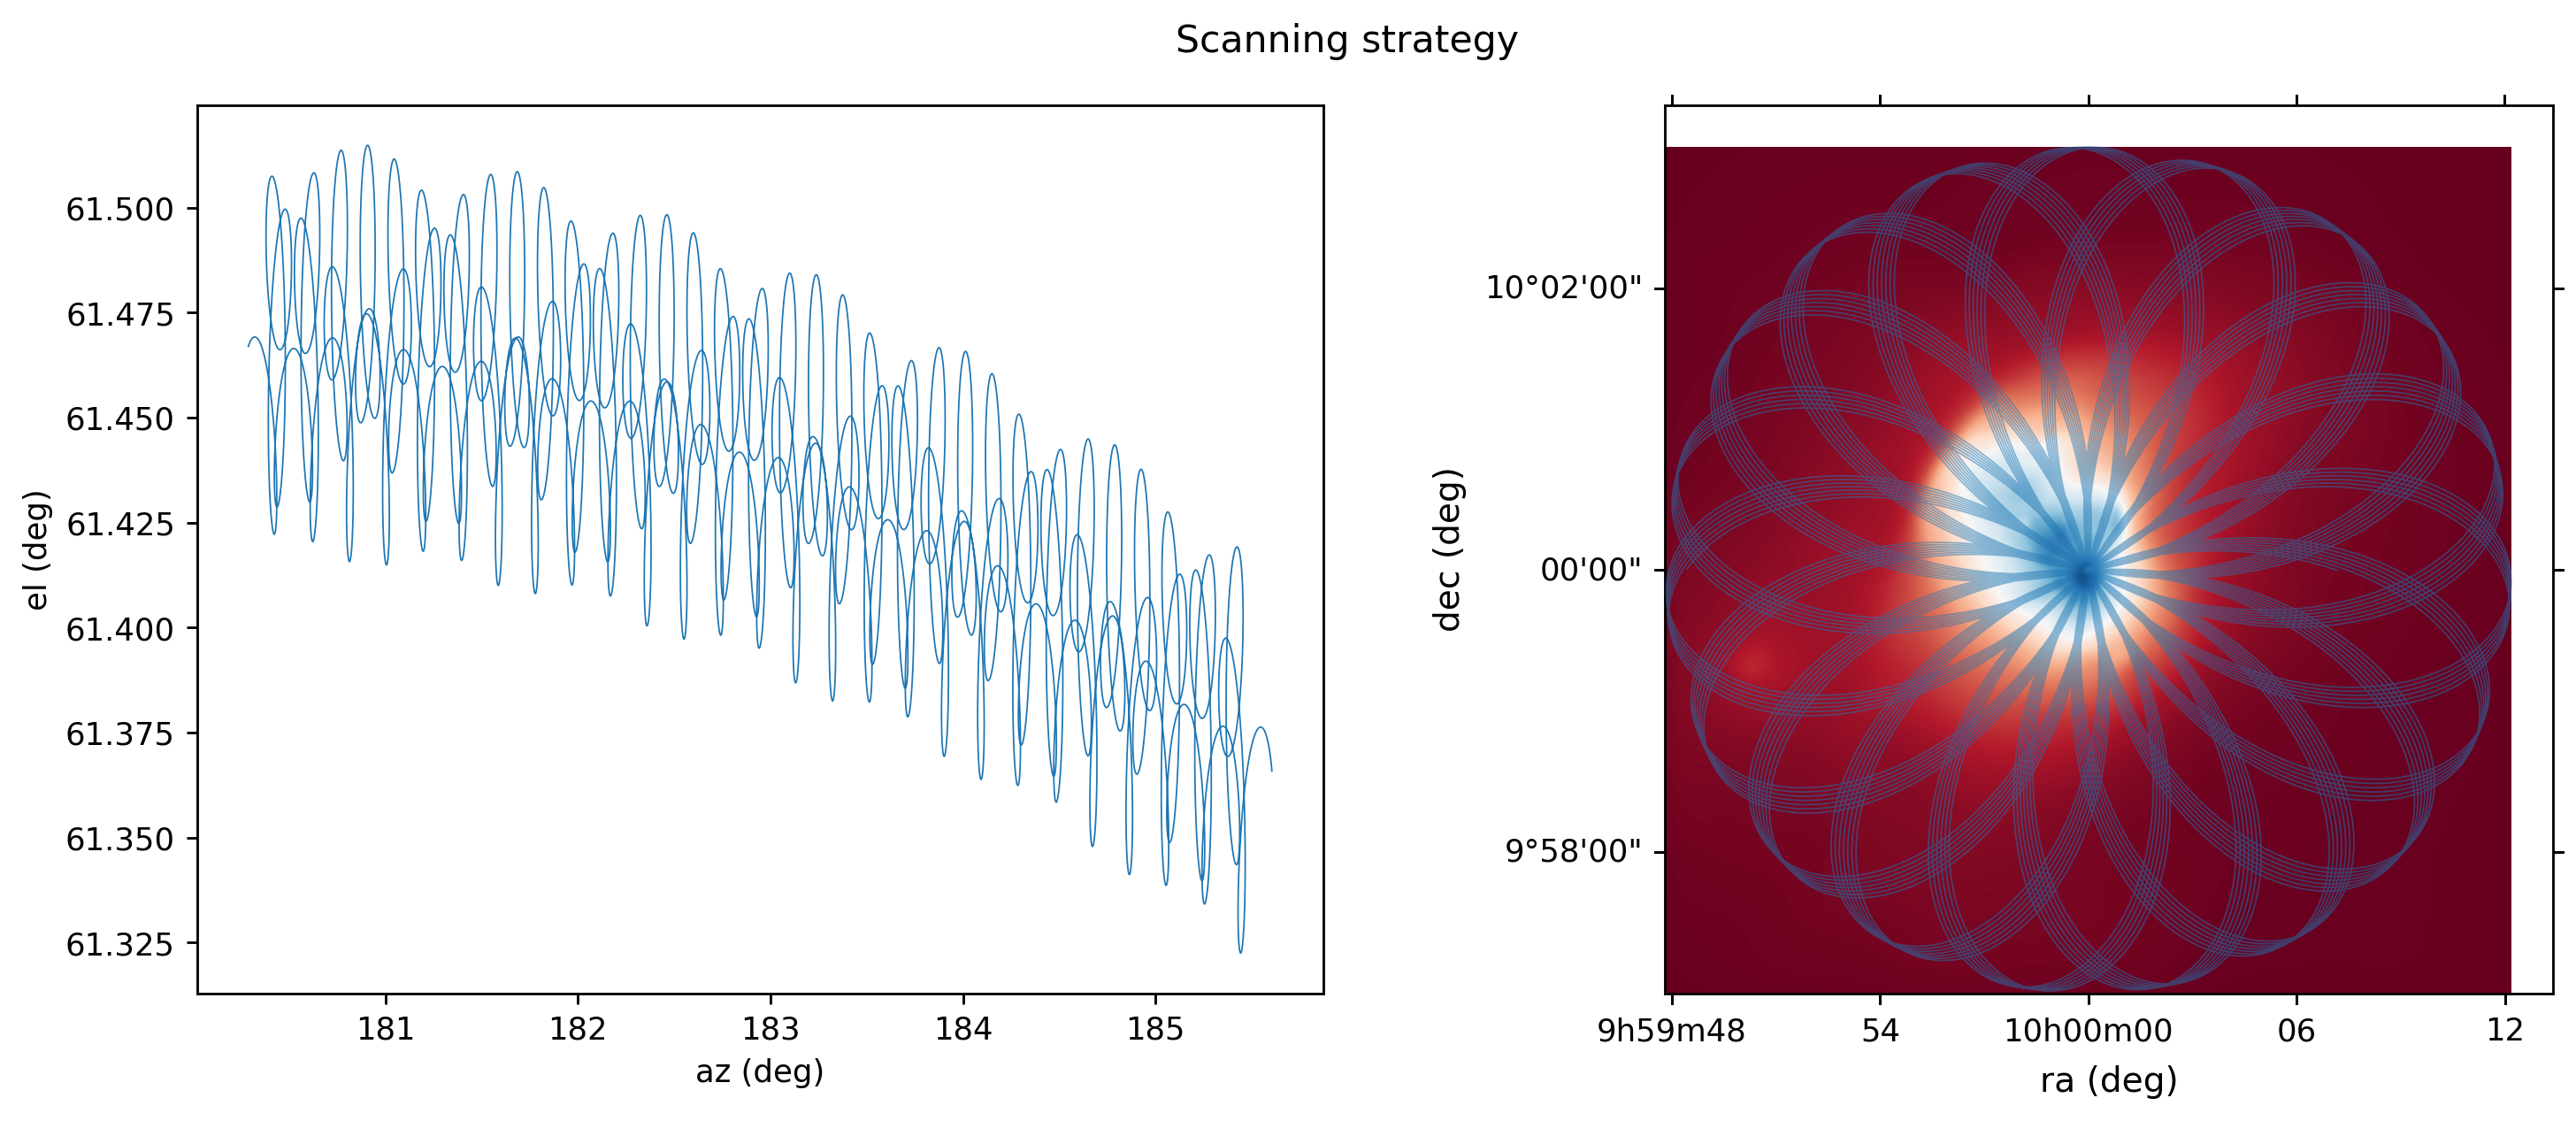

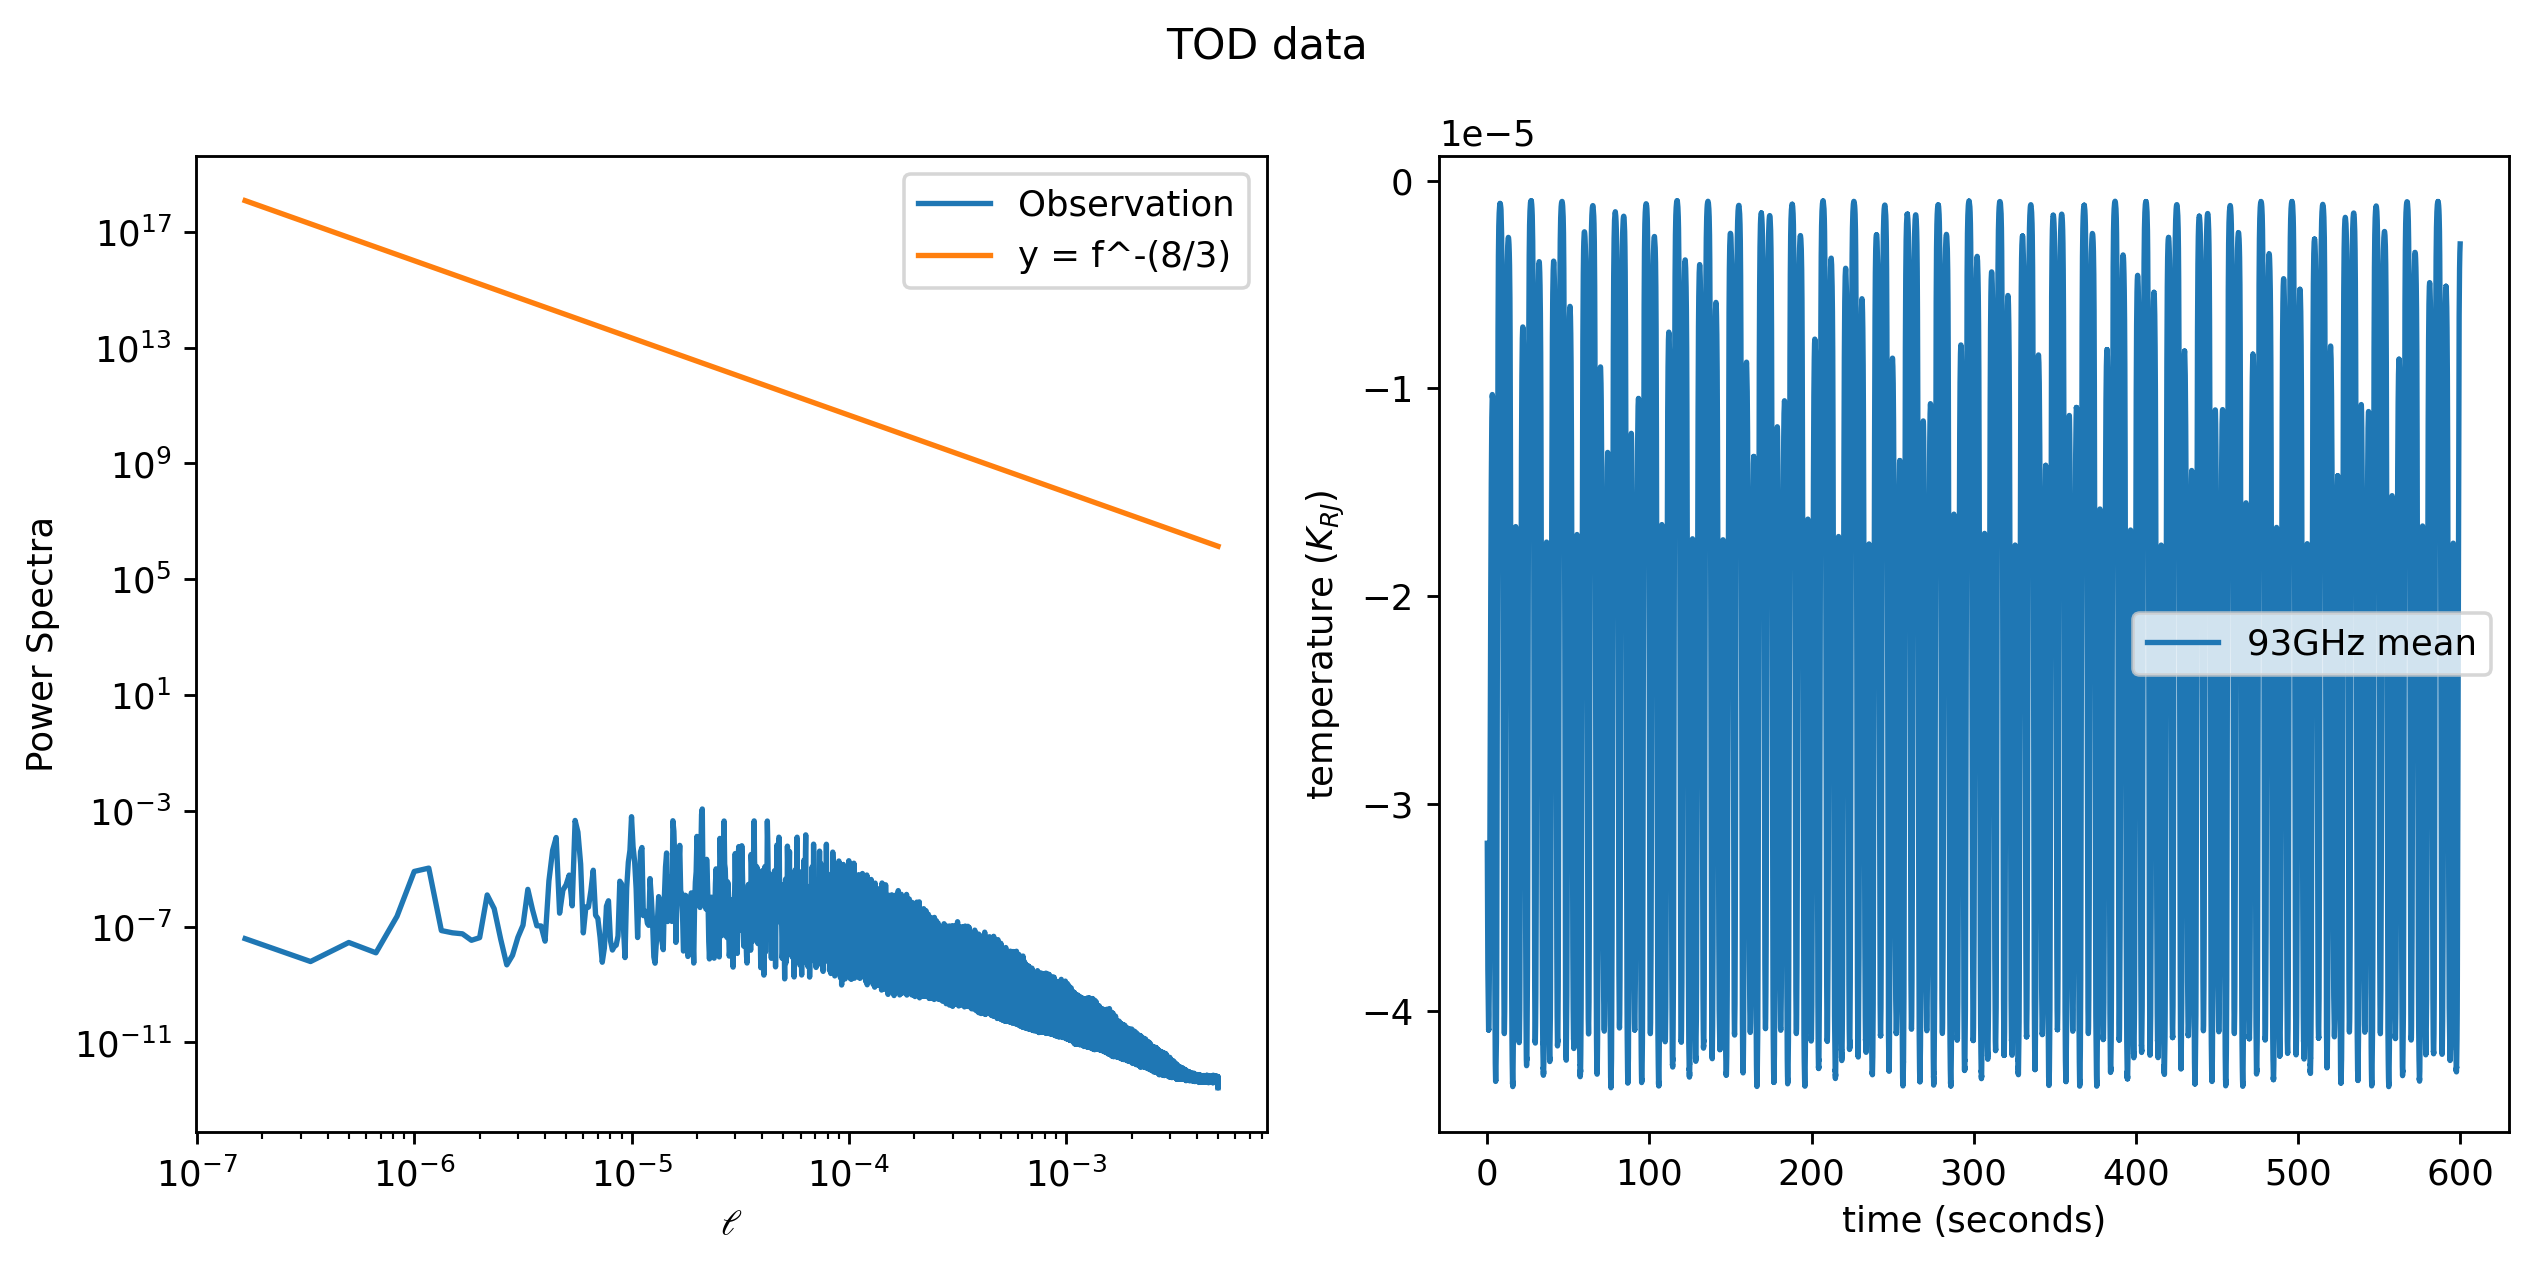

In [8]:
# visualize scanning patern
# -----------------------
cmap = "RdBu_r"

fig = plt.figure(dpi=256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle("Scanning strategy")

# - Plot
ax = plt.subplot(
    1,
    2,
    1,
)

ax.plot(np.degrees(tod.az), np.degrees(tod.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1, 2, 2, projection=wcs_input)
im = ax.imshow(hdu[0].data, cmap=cmap)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.ra) * u.deg, np.degrees(tod.dec) * u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1, alpha=0.5)
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=tod.time[1] - tod.time[0], window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle("TOD data")
axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Observation")
axes[0].plot(f[1:], f[1:] ** (-8 / 3), label="y = f^-(8/3)")
axes[0].set_xlabel(r"$\mathscr{l}$"), axes[0].set_ylabel("Power Spectra")
axes[0].loglog(), axes[0].legend()

for uib, uband in enumerate(np.unique(tod.dets.band)):
    band_mask = tod.dets.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    axes[1].plot(tod.time - tod.time[0], band_mean, label=f"{uband} mean")

axes[1].set_xlabel("time (seconds)"), axes[1].set_ylabel(r"temperature ($K_{RJ}$)")
axes[1].legend()

plt.show()

## Mapping the TODs
To transform the TODs into images, you'll require a mapper. While you have the option to create your custom mapper using the saved TODs, we have also included a pre-implemented choice for your convenience. This built-in mapper follows a straightforward approach: it first fourier fitlers the time-streams to remove any noise smaller than the resolution of the dish and larger than the FOV. You can turn this filtering of by setting ```map_filter=False```. Then, we also remove the common mode in the timestream. We do this by removing the first eigenmode (set by ```n_modes_to_remove=1```). Then, the mapper structures the TOD on the specified grid. Notably, the mapper is designed to effectively eliminate correlated atmospheric noise among different scans, thereby enhancing the quality of the resulting images.

An example of how to run the mapper on the TOD is as follows:

In [9]:
mapper = mappers.BinMapper(
    map_height=np.radians(10 / 60),
    map_width=np.radians(10 / 60),
    map_res=np.radians(4 / 3600),
    map_filter=True,
    n_modes_to_remove=1,
)
mapper.add_tods(tod)
mapper.run()

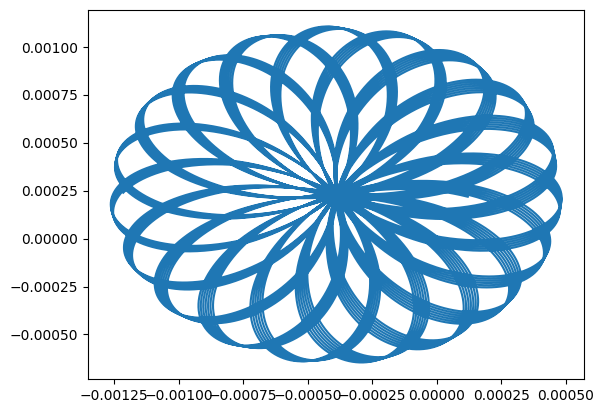

In [10]:
plt.plot(sim.map_sim.map_X[0], sim.map_sim.map_Y[1])

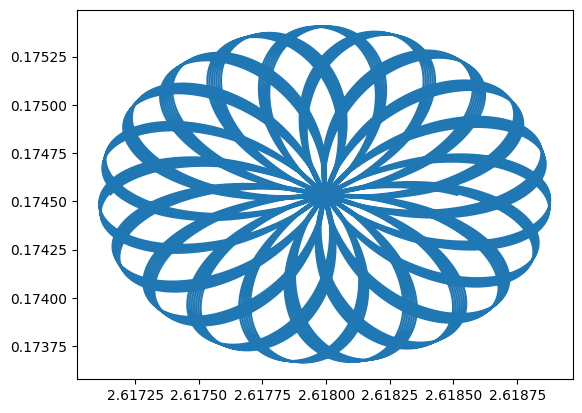

In [11]:
plt.plot(tod.ra, tod.dec)

The mapper utilizes the array information specified in the ```Simulation``` class. Below, I show the detector positions in the plane of the sky. The adjacent figure illustrates how many times a detector passed over a pixel on the map, which is related to map sensitivity and the specialized scanning strategy mentioned earlier.

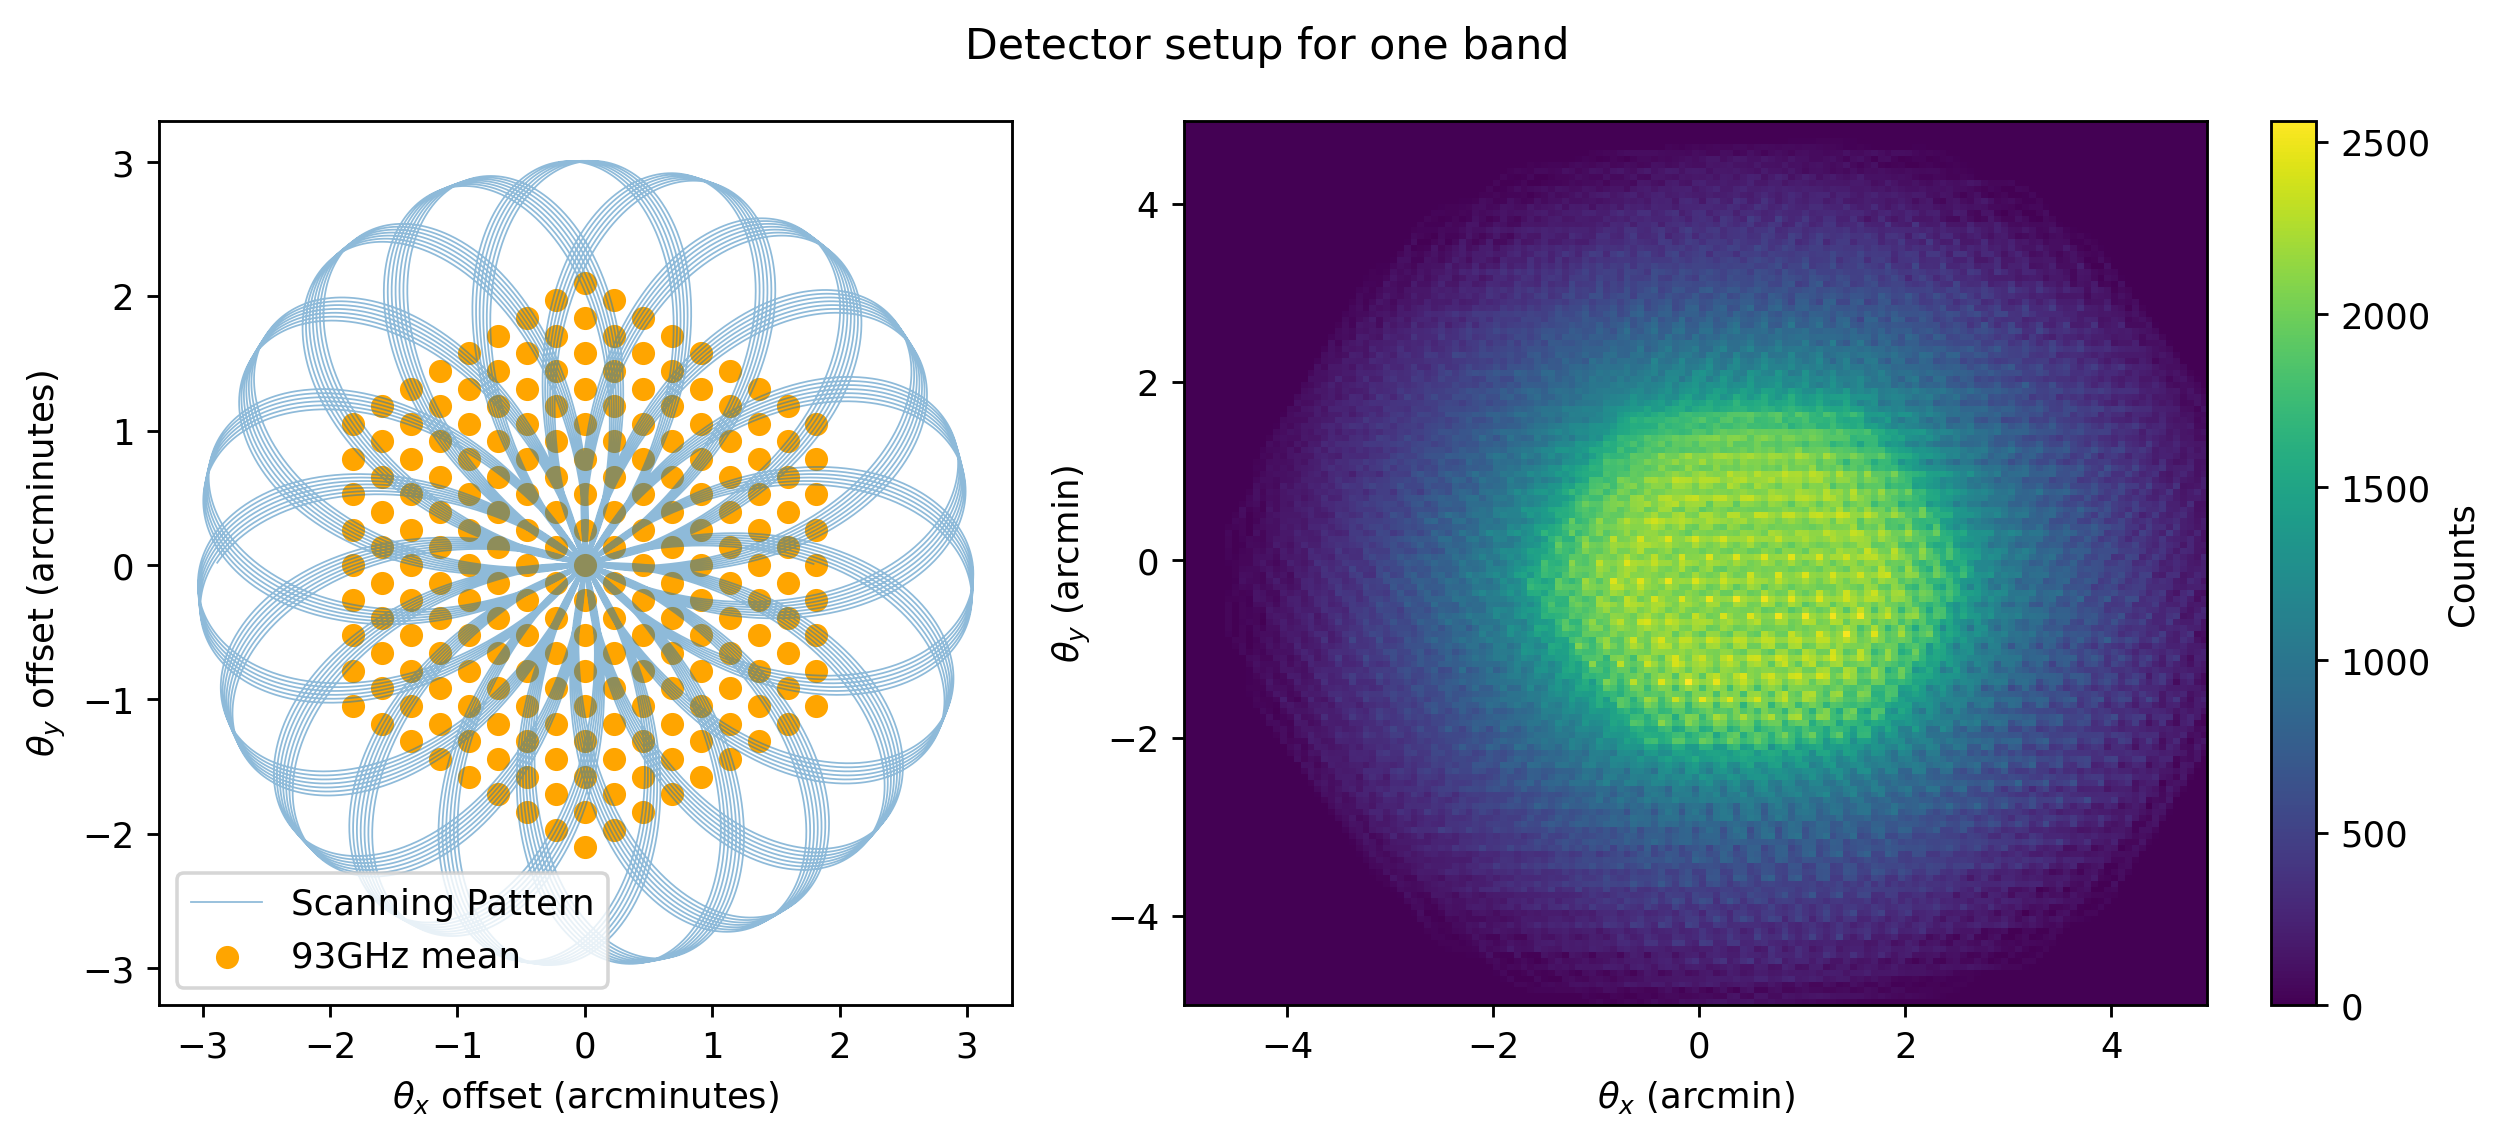

In [12]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4.5),
    dpi=256,
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 1.5]},
)
fig.suptitle("Detector setup for one band")

for uband in sim.array.ubands:
    band_mask = sim.array.dets.band == uband

    axes[0].plot(
        60 * np.degrees(tod.ra - tod.ra.mean()),
        60 * np.degrees(tod.dec - tod.dec.mean()),
        lw=5e-1,
        alpha=0.5,
        label="Scanning Pattern",
    )
    axes[0].scatter(
        60 * np.degrees(sim.array.offset_x[band_mask]),
        60 * np.degrees(sim.array.offset_y[band_mask]),
        label=f"{uband} mean",
        lw=5e-1,
        c="orange",
    )
    break
axes[0].set_xlabel(r"$\theta_x$ offset (arcminutes)"), axes[0].set_ylabel(
    r"$\theta_y$ offset (arcminutes)"
)
axes[0].legend()

xs, ys = np.meshgrid(
    60 * np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1]) / 2),
    60 * np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1]) / 2),
)

im = axes[1].pcolormesh(
    xs,
    ys,
    mapper.map_cnts[tod.dets.band[0]],
    label="Photon counts in band " + tod.dets.band[0],
)

axes[1].set_xlabel(r"$\theta_x$ (arcmin)"), axes[1].set_ylabel(r"$\theta_y$ (arcmin)")
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Counts")
plt.show()

## Visualizing the maps
As interesting as the detector setup, power spectra, and time series are, the goal of this module is to create synthetic images. In order to do that, we first save the maps to fits files, simply by running ```mapper.save_maps()```. This will output the fits and update the header according to the newly set observations. The units of the fits file are the same as specified in the ```Simulation``` class, so in Jy/pixel or in Kelvin Rayleigh Jeans. The saved fits file is a cube with axis (number of bands, pixels, pixels).

In [22]:
mapper.save_maps("/tmp/test.fits")

Below, we will visualize the maps we made, this is the final product. 

/Users/tom/opt/anaconda3/envs/maria/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


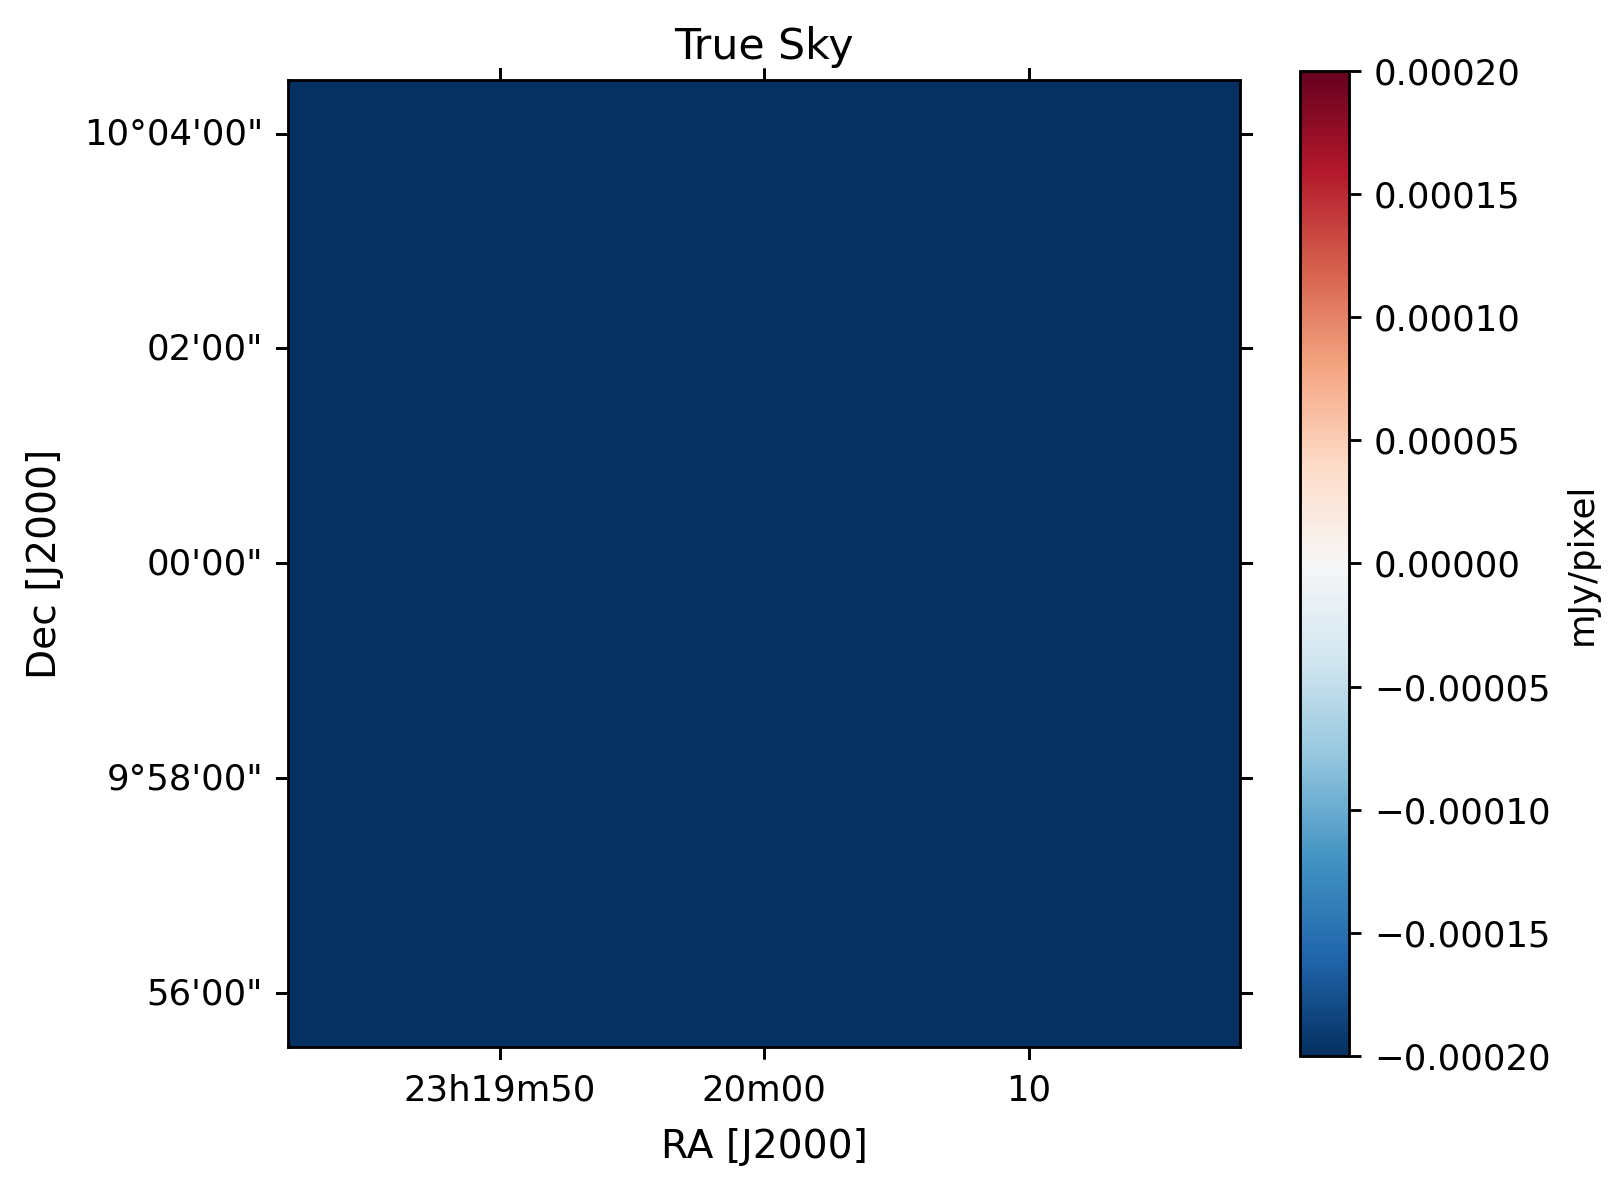

InvalidTransformError: ERROR 7 in wcsset() at line 2660 of file cextern/wcslib/C/wcs.c:
Ill-conditioned coordinate transformation parameter.
ERROR 4 in celset() at line 441 of file cextern/wcslib/C/cel.c:
Ill-conditioned coordinate transformation parameters
No valid solution for latp for these values of phip, phi0, and theta0.


In [26]:
sky_l = SkyCoord(
    (pointing_center[0] - 4.5 / 60) * u.deg, (pointing_center[1] - 4.5 / 60.0) * u.deg
)
sky_u = SkyCoord(
    (pointing_center[0] + 4.5 / 60) * u.deg, (pointing_center[1] + 4.5 / 60.0) * u.deg
)

fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 5, forward=True)

# - Plot Input sky
ax = plt.subplot(1, 1, 1, projection=wcs_input)
ax.set_title("True Sky")
im = ax.imshow(hdu[0].data * 1e3, vmin=-0.0002, vmax=0.0002, cmap=cmap)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label("mJy/pixel")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
ax.axis(
    xmin=pixel_sky_l[0], ymin=pixel_sky_l[1], xmax=pixel_sky_u[0], ymax=pixel_sky_u[1]
)

plt.show()

# - Plot Mock observation
outputfile = "/tmp/test.fits"

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)

# - Plot
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 5, forward=True)

ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Filtered Sky")
im = ax.imshow(hdu_out[0].data[0] * 1e3, vmin=-0.01, vmax=0.01, cmap=cmap)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label("mJy/pixel")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)
ax.axis(
    xmin=pixel_sky_l[0], ymin=pixel_sky_l[1], xmax=pixel_sky_u[0], ymax=pixel_sky_u[1]
)

plt.show()

# AtLAST Predictions
Here, you can find another example of using this simulation tool for predictions. But now, in this scenario, we'll adjust all parameters to align with the AtLAST telescope design. AtLAST will have with a broad 2-degree field of view (FOV) and offers a 10" resolution at 150 GHz. This configuration provides a more comprehensive, high spatial dynamic range, ideal for observing phenomena such as the Sunyaev-Zeldovich effect in galaxy clusters.

In [17]:
pointing_center = (-10.0, 10.0)
pixel_size = 0.001
integration_time = 10.0 * 60.0

map_file = "../../../maps/SZ_pairs_c0001_s127_x-y-vz_p00_Jy.fits"  # Input files must be a fits file.

In [18]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.coordinates import SkyCoord

# - Input figure
inputfile = map_file

hdu = fits.open(inputfile)
hdu[0].data = hdu[0].data
header = hdu[0].header
header["CDELT1"] = -1 * pixel_size  # degree
header["CDELT2"] = pixel_size  # degree
header["CTYPE1"] = "RA---SIN"
header["CUNIT1"] = "deg     "
header["CTYPE2"] = "DEC--SIN"
header["CUNIT2"] = "deg     "

header["CRVAL1"] = pointing_center[0]
header["CRVAL2"] = pointing_center[1]
wcs_input = WCS(header, naxis=2)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### Fine-Tuning Simulation Parameters

To make predictions for AtLAST, several adjustments are required. Firstly, we need to change the pointing center. AtLAST is located near the APEX telescope in the southern hemisphere, so we set the pointing center to a Declination of -10. Additionally, we need to chance the atmospheric conditions. The defeault is set to mid-February at 6 am UT, which is an ideal time for observing with MUSTANG-2 on the GBT but not for AtLAST at Chajnantor. To achieve this, we modify the `start_time` key to August. This change also necessitates adjusting the Right Ascension (RA) of the pointing to ensure that the source remains above the horizon during the observation.

Furthermore, we overwrite the field of view to be 2 degrees and set the scan radius of the daisy scan to 1.3 degrees. We also adjust the detector bandwidth to 52 GHz with a total of 2000 detectors, and set a scan period of 120 seconds. 

Now, it's important to note that we haven't yet developed a mapper that can handle AtLAST's large FOV. Most of the contamination will likely be a common mode in the atmosphere, which needs proper Fourier filtering. This aspect is still a work in progress. Therefore, for the time being, we conduct noiseless observations by setting `atm_model = None`.

In [20]:
sim = Simulation(
    # Mandatory minimal weither settings
    # ---------------------
    array="AtLAST",  # Array type
    pointing="daisy",  # Scanning strategy
    site="APEX",  # Site
    # atm_model = 'single_layer',  # The atmospheric model, set to None if you want a noiseless observation.
    atm_model=None,  # The atmospheric model, set to None if you want a noiseless observation.
    # True sky input
    # ---------------------
    map_file=map_file,  # Input files must be a fits file.
    # map_file can also be set to None if are only interested in the noise
    map_center=pointing_center,  # RA & Dec in degree
    # Defeault Observational setup
    # ----------------------------
    integration_time=integration_time,  # seconds
    scan_center=pointing_center,  # degrees
    pointing_frame="ra_dec",  # frame
    scan_radius=1.3,  # Scanning radius in degrees
    field_of_view=2.0,
    start_time="2022-08-10T06:00:00",
    scan_period=100.0,
    sample_rate=150.0,
    # Additional inputs:
    # ----------------------
    weather_quantiles={
        "column_water_vapor": 0.1
    },  # Weather conditions specific for that site
    map_units="Jy/pixel",  # Kelvin Rayleigh Jeans (K, defeault) or Jy/pixel
    map_res=pixel_size,  # degree, overwrites header information
)


KeyboardInterrupt



In [ ]:
tod = sim.run()

### Visualizing the TOD Data

In this section, we present the same array and TOD visualizations as in the MUSTANG-2 case, but this time for AtLAST:

In [ ]:
# visualize scanning patern
# -----------------------
fig = plt.figure(dpi=256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle("Scanning strategy")

# - Plot
ax = plt.subplot(
    1,
    2,
    1,
)

ax.plot(np.degrees(tod.az), np.degrees(tod.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1, 2, 2, projection=wcs_input)
im = ax.imshow(hdu[0].data, cmap=cmap)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.ra) * u.deg, np.degrees(tod.dec) * u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1, alpha=0.5, c="yellow")
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=tod.time[1] - tod.time[0], window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=256, tight_layout=True)
fig.suptitle("TOD data")
axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Observation")
axes[0].plot(f[1:], f[1:] ** (-8 / 3), label="y = f^-(8/3)")
axes[0].set_xlabel(r"$\mathscr{l}$"), axes[0].set_ylabel("Power Spectra")
axes[0].loglog(), axes[0].legend()

for uib, uband in enumerate(np.unique(tod.dets.band)):
    band_mask = tod.dets.band == uband
    band_mean = tod.data[band_mask].mean(axis=0)
    axes[1].plot(tod.time - tod.time[0], band_mean, label=f"{uband} mean")

axes[1].set_xlabel("time (seconds)"), axes[1].set_ylabel(r"temperature ($K_{RJ}$)")
axes[1].legend()

plt.show()

## Map-Making

As previously mentioned, we must disable Fourier filtering. Additionally, we have adjusted the height and width of the map to match the realistic AtLAST field of view, which spans several degrees.

In [ ]:
mapper = mappers.BinMapper(
    map_height=np.radians(4.5),
    map_width=np.radians(4.5),
    map_res=np.radians(pixel_size),
    map_filter=False,
    n_modes_to_remove=1,
)
mapper.add_tods(tod)
mapper.run()

In [ ]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4.5),
    dpi=256,
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 1.5]},
)
fig.suptitle("Detector setup for one band")

for uband in sim.array.ubands:
    band_mask = sim.array.dets.band == uband

    axes[0].plot(
        60 * np.degrees(tod.ra - tod.ra.mean()),
        60 * np.degrees(tod.dec - tod.dec.mean()),
        lw=5e-1,
        alpha=0.5,
    )
    axes[0].scatter(
        60 * np.degrees(sim.array.offset_x[band_mask]),
        60 * np.degrees(sim.array.offset_y[band_mask]),
        label=f"{uband} mean",
        lw=5e-1,
        c="orange",
    )
    break
axes[0].set_xlabel(r"$\theta_x$ offset (arcminutes)"), axes[0].set_ylabel(
    r"$\theta_y$ offset (arcminutes)"
)
axes[0].legend()

xs, ys = np.meshgrid(
    60 * np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1]) / 2),
    60 * np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1]) / 2),
)

im = axes[1].pcolormesh(
    xs,
    ys,
    mapper.map_cnts[tod.dets.band[0]],
    label="Photon counts in band " + tod.dets.band[0],
)

axes[1].set_xlabel(r"$\theta_x$ (arcmin)"), axes[1].set_ylabel(r"$\theta_y$ (arcmin)")
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Counts")
plt.show()

## Save & Visualize

In [ ]:
mapper.save_maps("/tmp/test2.fits")

In [ ]:
sky_l = SkyCoord((pointing_center[0] - 4) * u.deg, (pointing_center[1] - 4) * u.deg)
sky_u = SkyCoord((pointing_center[0] + 4) * u.deg, (pointing_center[1] + 4) * u.deg)

fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_input)
ax.set_title("True Sky")
im = ax.imshow(hdu[0].data * 1e3, cmap=cmap)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
ax.axis(
    xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1]
)
plt.show()

# - Mock observation
outputfile = "/tmp/test2.fits"

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)


fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Filtered Sky")
im = ax.imshow(hdu_out[0].data[0] * 1e3, cmap=cmap, vmax=0)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label("mJy/pixel")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r" ", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)
ax.axis(
    xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1]
)

plt.show()

## Fidelity Test

To gain insight into how the scanning strategy influences the quality of the observation, we've created a simple fidelity map. This map illustrates how modifying the scanning strategy impacts the recovery of your science. In particular, the sampling rate and scanning period have a significant influence on the image's fidelity. We are continually working on optimizing the scanning strategy for AtLAST, but you are welcome to experiment with these values yourself to observe their effect on the fidelity map.

In [ ]:
from reproject import reproject_interp

sim_projected, footprint = reproject_interp(
    (hdu[0].data, wcs_input), wcs_output, shape_out=hdu_out[0].data[0].shape
)

In [ ]:
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(12, 5, forward=True)

# - Plot
ax = plt.subplot(1, 1, 1, projection=wcs_output)
ax.set_title("Weighted Ratio")
im = ax.imshow((sim_projected / hdu_out[0].data[0]) - 1, cmap=cmap, vmin=-2, vmax=5)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
# cbar.set_label('mock/sim - 1')

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)
ax.axis(
    xmax=pixel_sky_l[0], ymin=pixel_sky_l[1], xmin=pixel_sky_u[0], ymax=pixel_sky_u[1]
)

plt.show()